In [1]:
# Importing necessary libraries
# os: to interact with the file system (load image paths)
# PIL: for image handling (loading and transforming images)
# torch: for deep learning tasks
# torchvision: for handling image datasets and pre-built models
# matplotlib: for plotting and visualizing data
# sklearn: for calculating precision, recall, f1-score, and confusion matrix
import os
from PIL import Image, ImageFile
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns

# Allow the loading of images even if they are corrupted
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Ensure that we are using a GPU if available, otherwise, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define a custom dataset class for loading our images and labels
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # root_dir: where the images are stored
        # transform: any image transformations to apply (e.g., resizing, normalizing)
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []  # List to store image paths
        self.labels = []       # List to store image labels (0 for real, 1 for fake)

        # Loop through the directory and load image paths and labels
        for file_name in os.listdir(root_dir):
            if file_name.endswith('.png'):  # If the file is a PNG image
                # Determine the label: "real" in the filename gives label 0, otherwise label 1
                if file_name[:4].lower() == "real":
                    label = 0
                else:
                    label = 1
                self.image_paths.append(os.path.join(root_dir, file_name))  # Store the image path
                self.labels.append(label)  # Store the corresponding label

    # Returns the total number of images
    def __len__(self):
        return len(self.image_paths)

    # Load an image and apply the transformations, then return the image and its label
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]  # Get the path of the image at index `idx`
        image = Image.open(img_path).convert("RGB")  # Load the image and convert it to RGB
        label = self.labels[idx]  # Get the label for the image

        # If any transformations (e.g., resizing, normalization) are defined, apply them
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Define transformations to be applied to each image (resizing, converting to tensor, normalizing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert image to a tensor (used by PyTorch)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the image with mean and standard deviation
                         std=[0.229, 0.224, 0.225]),])

In [6]:
# Create dataset and dataloader objects for training and validation datasets
train_dataset = CustomDataset(root_dir="../p_deepfake/datasets/dffmd_images/train", transform=transform)
val_dataset = CustomDataset(root_dir="../p_deepfake/datasets/dffmd_images/val", transform=transform)



# Create DataLoaders to efficiently load data in batches
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [7]:
# Load a pre-trained MobileNetV2 model from torchvision
model = models.mobilenet_v2(pretrained=True)
# Modify the last layer of the model for binary classification (2 classes: real and fake)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
# Move the model to the GPU if available
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Define the loss function (cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Adam optimizer to update model weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# Training for one epoch (1 full cycle through the data)
num_epochs = 1
# Lists to store loss and accuracy values for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
# To store all predictions and labels for calculating metrics later
all_preds, all_labels = [], []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # To accumulate loss over the epoch
    running_correct = 0  # To count correct predictions
    total = 0  # Total number of samples processed

    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradient (clear the gradients for this step)

        # Forward pass: get model outputs
        outputs = model(images)

        # Calculate loss between model outputs and true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the model weights
        optimizer.step()

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class (index of max value)
        total += labels.size(0)  # Keep track of total samples
        running_correct += (predicted == labels).sum().item()  # Count correct predictions

        # Collect predictions and labels for metrics later
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)

        # Calculate running average loss and accuracy over all batches so far
        running_loss_avg = running_loss / (batch_idx + 1)
        running_accuracy_avg = 100 * running_correct / total

        train_losses.append(running_loss_avg)  # Save running average loss
        train_accuracies.append(running_accuracy_avg)  # Save running average accuracy

        print(f"Batch {batch_idx+1}/{len(train_loader)}, "
              f"Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_accuracy:.2f}%, "
              f"Running Avg Loss: {running_loss_avg:.4f}, Running Avg Accuracy: {running_accuracy_avg:.2f}%")

    # Validation step: checking how well the model performs on unseen data
    model.eval()  # Set model to evaluation mode (no gradient updates)
    val_loss = 0.0  # Accumulate validation loss
    val_correct = 0  # Count correct validation predictions
    val_total = 0  # Total validation samples
    val_preds, val_labels = [], []  # Store validation predictions and labels

    # Turn off gradient calculation for validation (improves speed and memory)
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_loss += loss.item()  # Accumulate validation loss

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)  # Keep track of total validation samples
            val_correct += (predicted == labels).sum().item()  # Count correct predictions

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate average validation loss and accuracy
    val_loss_avg = val_loss / len(val_loader)
    val_accuracy_avg = 100 * val_correct / val_total

    val_losses.append(val_loss_avg)  # Save validation loss
    val_accuracies.append(val_accuracy_avg)  # Save validation accuracy

    print(f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy_avg:.2f}%\n")


Epoch 1/1
Batch 1/108, Batch Loss: 0.8776, Batch Accuracy: 50.78%, Running Avg Loss: 0.8776, Running Avg Accuracy: 50.78%
Batch 2/108, Batch Loss: 0.6966, Batch Accuracy: 56.25%, Running Avg Loss: 0.7871, Running Avg Accuracy: 53.52%
Batch 3/108, Batch Loss: 0.5427, Batch Accuracy: 78.12%, Running Avg Loss: 0.7056, Running Avg Accuracy: 61.72%
Batch 4/108, Batch Loss: 0.3799, Batch Accuracy: 94.53%, Running Avg Loss: 0.6242, Running Avg Accuracy: 69.92%
Batch 5/108, Batch Loss: 0.3983, Batch Accuracy: 84.38%, Running Avg Loss: 0.5790, Running Avg Accuracy: 72.81%
Batch 6/108, Batch Loss: 0.2484, Batch Accuracy: 96.09%, Running Avg Loss: 0.5239, Running Avg Accuracy: 76.69%
Batch 7/108, Batch Loss: 0.2532, Batch Accuracy: 95.31%, Running Avg Loss: 0.4852, Running Avg Accuracy: 79.35%
Batch 8/108, Batch Loss: 0.1876, Batch Accuracy: 93.75%, Running Avg Loss: 0.4480, Running Avg Accuracy: 81.15%
Batch 9/108, Batch Loss: 0.1776, Batch Accuracy: 94.53%, Running Avg Loss: 0.4180, Running Avg

In [10]:
# Calculate precision, recall, and F1-score using validation predictions and labels
precision = precision_score(val_labels, val_preds, average="weighted")
recall = recall_score(val_labels, val_preds, average="weighted")
f1 = f1_score(val_labels, val_preds, average="weighted")

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


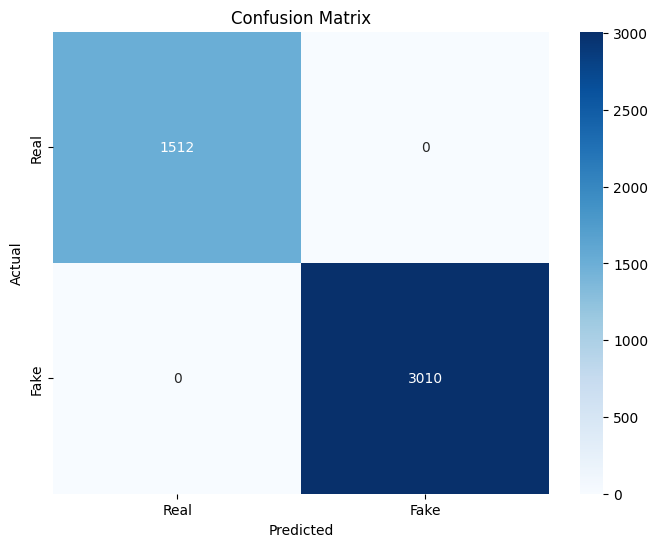

In [11]:
# Create and display a confusion matrix to understand model errors
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8,6))  # Set plot size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])  # Display matrix
plt.title("Confusion Matrix")  # Add title
plt.ylabel('Actual')  # Label for y-axis
plt.xlabel('Predicted')  # Label for x-axis
plt.show()  # Show the plot

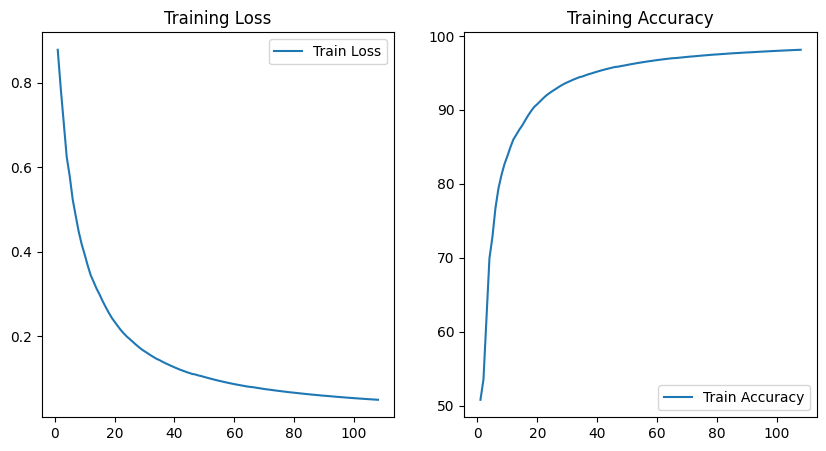

In [12]:
# Plot training loss and accuracy over batches
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Subplot for training loss
plt.plot(epochs_range, train_losses, label='Train Loss')  # Plot train loss
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1, 2, 2)  # Subplot for training accuracy
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')  # Plot train accuracy
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()  # Show the plots

In [13]:
# Save the trained model to a file
torch.save(model.state_dict(), 'dffmd_lite.pth')

In [14]:
# Reload the saved model for later use
model = models.mobilenet_v2(pretrained=False)
model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
model.load_state_dict(torch.load('dffmd_lite.pth'))  # Load the saved model state
model = model.to(device)
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
# Optimize the model for mobile deployment
from torch.utils.mobile_optimizer import optimize_for_mobile

# Convert model to a TorchScript model for mobile
traced_script_module = torch.jit.script(model.cpu())

# Optimize the scripted model for mobile
traced_script_module_optimized = optimize_for_mobile(traced_script_module)

# Save the optimized model for mobile inference (Lite interpreter)
traced_script_module_optimized._save_for_lite_interpreter("dffmd_lite_traced.ptl")

In [16]:
# Load the optimized mobile model and evaluate it
lite_model = torch.jit.load("dffmd_lite_traced.ptl")  # Load the mobile-optimized model
lite_model.eval()  # Set the model to evaluation mode

# Evaluate the Lite model on the validation dataset
val_loss_lite = 0.0
val_correct_lite = 0
val_total_lite = 0

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in val_loader:
        images, labels = images.cpu(), labels.cpu()  # Move images and labels to CPU

        # Forward pass through the Lite model
        outputs_lite = lite_model(images)
        loss_lite = criterion(outputs_lite, labels)  # Calculate loss for the Lite model
        val_loss_lite += loss_lite.item()

        # Get predicted labels from the model outputs
        _, predicted_lite = torch.max(outputs_lite.data, 1)
        val_total_lite += labels.size(0)  # Count total validation samples
        val_correct_lite += (predicted_lite == labels).sum().item()  # Count correct predictions

# Calculate and print validation loss and accuracy for the Lite model
val_loss_avg_lite = val_loss_lite / len(val_loader)
val_accuracy_avg_lite = 100 * val_correct_lite / val_total_lite

print(f"Lite Model Validation Loss: {val_loss_avg_lite:.4f}, Validation Accuracy: {val_accuracy_avg_lite:.2f}%")

Lite Model Validation Loss: 0.0008, Validation Accuracy: 100.00%
